In [2]:
import numpy as np 
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

## Mapping the problem to a quantum architecture 

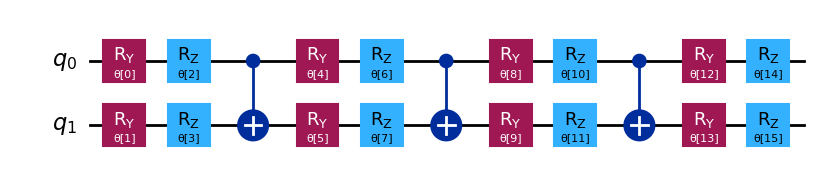

In [3]:
# Example Hamiltonian problem
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

# Ansatz = an educated first-iteration guess about the solution which gets iteratively updated. 
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [4]:
# There are 16 parameters as we can deduce from the circuit diagram. We can also print this number. 
num_params = ansatz.num_parameters
num_params

16

## Optimization for quantum execution

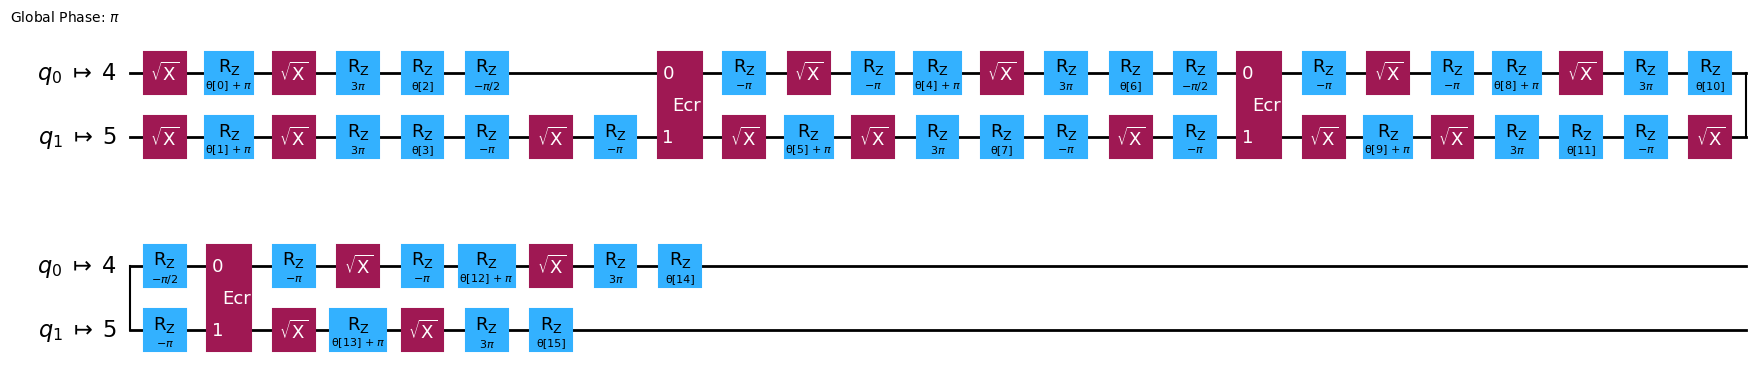

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target = target, optimization_level=3) # Optimization level is selected based on a calculus of quantum decoherence for large system vs gate count efficiency. 
ansatz_isa = pm.run(ansatz)

ansatz_isa.draw(output = "mpl", idle_wires = False, style = "iqp")

In [6]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## Execution with quantum primitives 

In [7]:
def cost_func(params, ansatz, hamiltonian, estimator): 
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs = [pub]).result()
    energy = result[0].data.evs[0]
    
    cost_history_dict["iterations"] += 1 
    cost_history_dict["previous_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iterations done: {cost_history_dict['iterations']} [Current cost: {energy}]")
    
    return energy

In [8]:
cost_history_dict = {
    "previous_vector": None, 
    "iterations": 0,
    "cost_history": [],
}

In [8]:
# Minimizing the cost function using the constrained optimization by linear approximations (COBYLA routine): 

x0 = 2*np.pi*np.random.random(num_params)
x0

array([2.31879603, 4.25010008, 2.87425678, 5.66655972, 2.09952727,
       2.2169804 , 5.59435457, 4.89154302, 3.35011755, 3.14511136,
       2.34923851, 4.036638  , 1.56503346, 3.53450862, 0.57174447,
       1.96279398])

In [ ]:
with Session(backend=backend) as session: # to execute all generated circuits in one block
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000
    
    res = minimize(cost_func, x0, args = (ansatz_isa, hamiltonian_isa, estimator), method="cobyla")

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_80443/3321713173.py:2: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


Iterations done: 1 [Current cost: 0.3812318954360407]
Iterations done: 2 [Current cost: 0.47551866434399354]
Iterations done: 3 [Current cost: 0.39444385516360425]
Iterations done: 4 [Current cost: 0.42839053942280003]
Iterations done: 5 [Current cost: 0.021558705566182928]
Iterations done: 6 [Current cost: 0.1703122475808723]
Iterations done: 7 [Current cost: -0.2584936375902314]
Iterations done: 8 [Current cost: -0.24456103546404415]
Iterations done: 9 [Current cost: -0.5668923632551107]
Iterations done: 10 [Current cost: -0.5342142167018764]
Iterations done: 11 [Current cost: -0.2522497698917411]
Iterations done: 12 [Current cost: -0.5062594670446803]
Iterations done: 13 [Current cost: -0.5958823966873428]
Iterations done: 14 [Current cost: -0.21567097484361156]
Iterations done: 15 [Current cost: -0.3362410037954598]
Iterations done: 16 [Current cost: -0.4593600368341716]
Iterations done: 17 [Current cost: -0.21671326170141408]
Iterations done: 18 [Current cost: -0.3037865445207067]

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    f = sf.fun(x)
        ^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 267, in fun
    self._update_fun()
  File "/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
    self._update_fun_impl()
  File "/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
    self.f = fun_wrapped(self.x)
             ^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = 

In [64]:
job_id = "cvm4a50p7drg008me21g"
retrieved_job = service.job(job_id)

for idx, pub_result in enumerate(retrieved_job.result()):
    print(f"Expectation values for energy: {pub_result.data.evs}")

Expectation values for energy: [-0.49059596]


## Post-processing

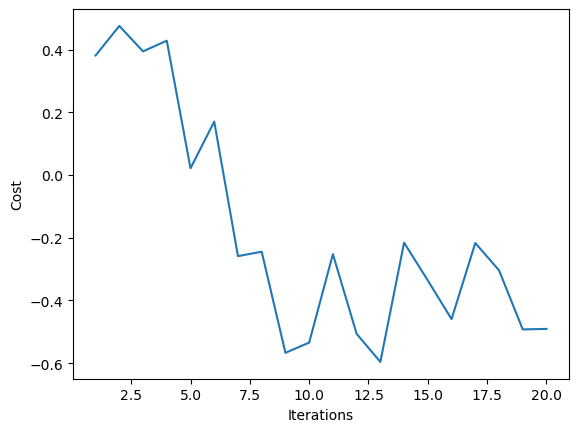

In [66]:
# Doing manually because jobs don't save all intermediate processes and I am out of IBM open-plan run time. 
X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Y = [0.3812318954360407, 0.47551866434399354, 0.39444385516360425, 0.42839053942280003, 0.021558705566182928, 0.1703122475808723, -0.2584936375902314, -0.24456103546404415, -0.5668923632551107, -0.5342142167018764, -0.2522497698917411, -0.5062594670446803, -0.5958823966873428, -0.21567097484361156, -0.3362410037954598, -0.4593600368341716, -0.21671326170141408, -0.3037865445207067, -0.49220310395623323, -0.4905959641592047]

fig, ax = plt.subplots()
ax.plot(X,Y)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [67]:
print("Sufficient iterations will show that the cost value converges at around -0.6.")

Sufficient iterations will show that the cost value converges at around -0.6.
